In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

In [2]:
def get_samples(N):
    return tfd.Uniform(low=[0,0], high=[1,1]).sample(N)

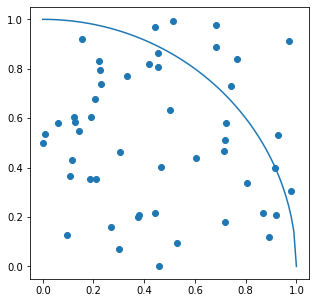

In [4]:
plt.figure(figsize=(5,5))
xs = tf.linspace(0., 1., 100)
plt.scatter(*tf.transpose(get_samples(50)))
plt.plot(xs, tf.sqrt(1 - xs**2))

In [7]:
def approx_pi(N):
    samples = get_samples(N)
    inside = (samples[:,0]**2 + samples[:,1]**2) <= 1
    inside = tf.cast(inside, tf.float32)
    return tf.reduce_mean(inside).numpy()*4

In [10]:
approx_pi(10)

3.5999999046325684

In [9]:
approx_pi(100)

3.0799999237060547

In [11]:
approx_pi(100000)

3.146120071411133

In [12]:
def approx_pi_many(N, k):
    return [approx_pi(N) for _ in range(k)]

In [13]:
Ns = [1000, 3000, 8000]

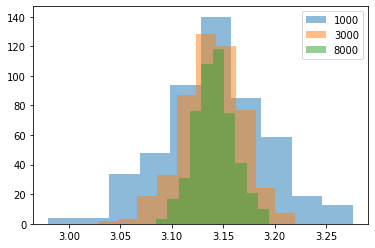

In [14]:
for N in Ns:
    plt.hist(approx_pi_many(N, 500), alpha=0.5, label=N)
plt.legend()

# Idea

Instead of sovling

$$\int f(x) p(x) \mathrm{d}x$$

get a sample of $x$ drawn from a distribution $X$ behaving like $p$, such that

$$\frac 1 N \sum_x f(x) \rightarrow \int f(x) p(x) \mathrm{d}x$$

for large samples of $x$.

## Metropolis Hastings

In [15]:
prob = lambda theta: tfd.Binomial(200, probs=theta).prob(112)

In [24]:
112/200

0.56

In [19]:
prob(1.5)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [40]:
# Note: Only need rations in Metropolis-Hastings
# This means e.g. I don't need to calculate binomial coefficients,
# which can be an issue
tfd.Binomial(500000, 0.52).prob(250012)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [54]:
state = tf.constant(0.4)
epsilon = 0.05
hist = []
accept = []
for _ in range(500):
    candidate = state + tfd.Uniform(-epsilon, epsilon).sample(1)[0]
    candidate = max(min(candidate, 1), 0) # restrict to [0, 1]
    alpha = prob(candidate) / prob(state)
    u = tfd.Uniform(0., 1.).sample(1)
    if u <= alpha:
        state = candidate
        accept.append(1.)
    else:
        accept.append(0.)
    hist.append(state.numpy())
print(f"accept ratio: {tf.reduce_mean(accept[50:])}")

accept ratio: 0.746666669845581


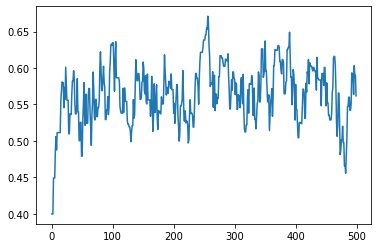

In [55]:
plt.plot(hist)

(array([ 3.,  8., 25., 84., 82., 96., 83., 46., 19.,  4.]),
 array([0.4557795 , 0.47729662, 0.49881375, 0.5203309 , 0.541848  ,
        0.5633651 , 0.58488226, 0.6063994 , 0.6279165 , 0.6494336 ,
        0.6709508 ], dtype=float32),
 <BarContainer object of 10 artists>)

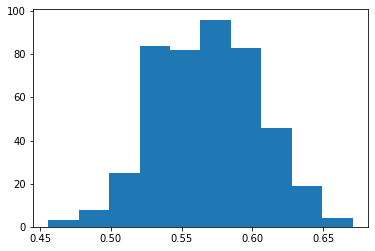

In [57]:
plt.hist(hist[50:])

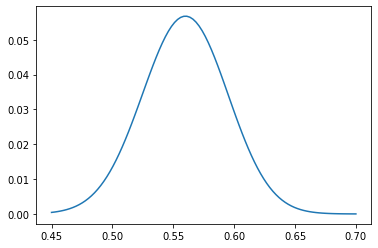

In [33]:
xs = tf.linspace(0.45, 0.7, 1000)
plt.plot(xs, prob(xs))

In [58]:
import numpy

In [60]:
(numpy.array(hist[50:]) > 0.5).mean()

0.9711111111111111

In [61]:
numpy.quantile(hist[50:], [0.05, .50, 0.95])

array([0.51241107, 0.56905138, 0.62818083])